In [1]:
#@title Load station and meteorological model. Save fusion file

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import seaborn as sns

path_result = "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/LEVXfusion.csv"

def transform_value_l(val):
    first_decimal = int(str(val)[2]) if len(str(val)) > 2 else 0
    return f'CL{first_decimal}'

def transform_value_m(val):
    first_decimal = int(str(val)[2]) if len(str(val)) > 2 else 0
    return f'CM{first_decimal}'

def transform_to_nearest_odd(arr):
    # Make a copy of the input array
    arr_copy = arr.copy()

    # Find even numbers
    even_indices = arr_copy % 2 == 0

    # Increment even numbers to the nearest odd number
    arr_copy[even_indices] += 1

    return arr_copy.astype(str)

def custom_round(value):
    if value > 9001:
        return str(9999)
    elif value < 1000:
        return str(500)
    else:
        return str(round(value / 1000) * 1000)



pd.options.display.max_rows = 999

station_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/LEVXY2018Y2022.csv",
                          parse_dates=["time"]).dropna().set_index("time")

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2022.csv",parse_dates=["time"])
df_all = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")


#wind direction to words
df_all["dir0_l"] = result = ["0" + c if len(c) == 2 else ("00" + c if len(c) == 1 else c) for c in (round(df_all["dir0"],-1).astype(int).astype(str))]
all = round(df_all["mod0"] * 1.94384, 0).astype(int).values
list_mod0 = ["0" + str(c) if len(c) == 1 else str(c) for c in transform_to_nearest_odd(all)]
df_all["wind"]=df_all["dir0_l"]+list_mod0+"kt"

#visibility words
"""
interval = pd.IntervalIndex.from_tuples([(-1.5, 20000),(20000,30000)])
labels = ['vi20d', 'vi20u']
df_all["visibility0_l"] = pd.cut(df_all["visibility0"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("str")
df_all[["visibility0_l","visibility0"]].sample(100)
"""
# Define the old and new min and max values
old_min = 26.731182
old_max = 24235.0
new_min = 50
new_max = 9999

# Calculate the scale (a) and shift (b) factors
a = (new_max - new_min) / (old_max - old_min)
b = new_min - a * old_min

df_all['visibility0_l'] = ((a * df_all['visibility0'] + b).round().astype(int)).apply(custom_round)

#rh in words
interval = pd.IntervalIndex.from_tuples([(-1.5, .80),(.80,100)])
labels = ['rhd80', 'rhu80']
df_all["rh0_l"] = pd.cut(df_all["rh0"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("str")
df_all[["rh0_l","rh0"]].sample(100)


#prec words
interval = pd.IntervalIndex.from_tuples([(-1.5, 0.1),(.1,180)])
labels = ['prec0n', 'prec0y']
df_all["prec0_l"] = pd.cut(df_all["prec0"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("str")
df_all[["prec0_l","prec0"]].sample(100)


#cfl words
df_all['cfl0_l'] = round(df_all["cfl0"],1).apply(transform_value_l)

#cfm words
df_all['cfm0_l'] = round(df_all["cfm0"],1).apply(transform_value_m)


#temp words
df_all["temp0_l"] = ["0" + c if len(c) == 1 else c for c in round(df_all["temp0"]-273.16,0).astype(int).astype(str)]

#temp dew words
df_all["tempd0_l"] = ["0" + c if len(c) == 1 else c for c in round((df_all["temp0"]-273.16)- (100 - df_all["rh0"]*100) / 5,0).astype(int).astype(str)]

#mslp words
pres = round(df_all["mslp0"]/100,0).astype(int).astype(str)
df_all["mslp0_l"] =[ "q"+p if len(p)==4 else "q0"+p for p in pres]

#time variables
df_all['hour'] = 'H' + df_all.index.hour.astype(str)
df_all['month'] = 'M' + df_all.index.month.astype(str)

#select variable met model
df_all["model_seed"]= df_all["wind"]+" "+df_all["visibility0_l"]+" "+df_all["prec0_l"]+" "+df_all["cfl0_l"]+" "+df_all["cfm0_l"]+" "+df_all["temp0_l"]+ " "+df_all["tempd0_l"]+" "+df_all["mslp0_l"]


station_raw["metar_o"] = station_raw["metar_o"].astype(str)
station_raw["metar_o"] = station_raw["metar_o"].str.split().apply(lambda x: ' '.join(x[2:]) if len(x) > 2 else '')

result = pd.concat([station_raw,df_all["model_seed"]],axis=1).dropna()
result["fusion"]= result["model_seed"]+" "+result["metar_o"]

#save fusion
result["fusion"].to_csv(path_result)

result["fusion"].sample(100).values

array(['30011kt 9999 prec0n CL1 CM0 19 13 q1016 32010KT 280V360 9999 FEW042 BKN051 20/12 Q1016 NOSIG',
       '01007kt 9999 prec0n CL0 CM0 16 13 q1033 03006KT 360V060 CAVOK 17/14 Q1032 NOSIG',
       '21005kt 9999 prec0n CL2 CM0 10 09 q1025 17003KT 080V200 6000 BCFG SCT002 SCT020 BKN035 10/10 Q1025 TEMPO 0800 BCFG BKN002',
       '15003kt 9999 prec0n CL0 CM0 16 14 q1015 04001KT CAVOK 18/15 Q1015 NOSIG',
       '02005kt 9999 prec0n CL0 CM0 06 03 q1020 00000KT CAVOK 07/03 Q1019 NOSIG',
       '16005kt 9999 prec0n CL0 CM0 07 04 q1025 25006KT 200V280 CAVOK 10/03 Q1024 NOSIG',
       '03003kt 9999 prec0n CL0 CM0 10 05 q1029 00000KT CAVOK 10/05 Q1028 NOSIG',
       '13005kt 500 prec0n CL5 CM0 11 11 q1020 21012KT 9999 BKN010 BKN015 13/12 Q1019 NOSIG',
       '27007kt 9999 prec0n CL0 CM5 17 14 q1011 28007KT 240V320 9000 TS SHRA FEW033CB 19/17 Q1013 NOSIG',
       '18007kt 9999 prec0n CL6 CM0 16 15 q1014 20010KT 160V230 9999 BKN003 BKN007 17/16 Q1014 TEMPO 3000 BR',
       '31005kt 9999 prec0n 

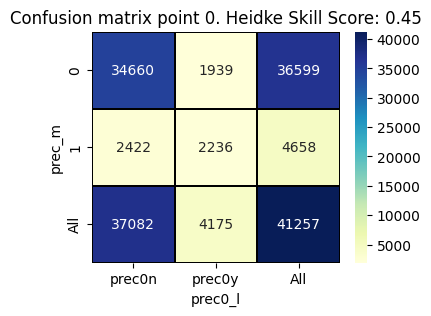

In [ ]:
#@title Precipitation
df_prec =pd.concat([df_all[["prec0_l","prec0"]],station_raw['wxcodes_o']],axis=1).dropna()
df_prec["prec_m"] = [1 if "RA" in c or "DZ" in c else 0 for c in df_prec["wxcodes_o"]]
df_prec

# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df_prec.prec_m, df_prec.prec0_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

,visibility0,visibility_o
visibility0,1.000000,0.377219
visibility_o,0.377219,1.000000


,visibility0,visibility_o,visibility0_l
count,41257.000000,41257.000000,41257.000000
mean,22447.542355,8476.335967,9308.377439
std,5676.803829,3078.104903,2362.733580
min,22.752291,48.000000,100.000000
25%,24043.914062,8996.000000,9999.000000
50%,24099.460938,9994.000000,9999.000000
75%,24135.000000,9994.000000,9999.000000
max,24235.000000,9994.000000,9999.000000


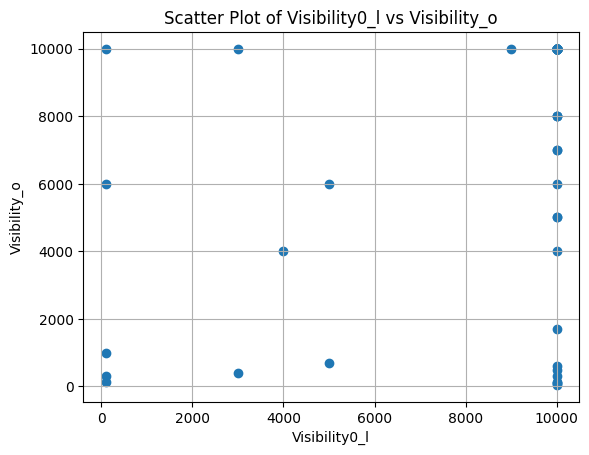

,visibility0,visibility_o,visibility0_l
time,,,
2018-10-06 10:00:00,24057.423828,9994.0,9999
2020-01-28 23:00:00,1229.147217,7998.0,100
2020-09-10 18:00:00,24135.000000,9994.0,9999
2020-11-29 23:00:00,24135.000000,9994.0,9999
2020-02-08 18:00:00,24092.064453,9994.0,9999
2018-12-14 21:00:00,24039.292969,306.0,9999
2018-08-23 10:00:00,24042.390625,4007.0,9999
2020-12-09 02:00:00,24231.822266,6003.0,9999
2020-05-15 11:00:00,24135.000000,9994.0,9999


visibility0_l
9999    37672
100      1894
3000      315
2000      300
4000      263
5000      178
7000      166
6000      157
1000      140
8000      115
9000       57
Name: count, dtype: int64

In [ ]:
#@title visibility0 vs visibility obs

def custom_round(value):
    if value > 9001:
        return 9999
    elif value < 1000:
        return 100
    else:
        return round(value / 1000) * 1000

df_vis = pd.concat([df_all["visibility0"],station_raw['visibility_o']],axis=1).dropna()
display(df_vis.corr())

# Define the old and new min and max values
old_min = 26.731182
old_max = 24235.0
new_min = 50
new_max = 9999

# Calculate the scale (a) and shift (b) factors
a = (new_max - new_min) / (old_max - old_min)
b = new_min - a * old_min

df_vis['visibility0_l'] = ((a * df_vis['visibility0'] + b).round().astype(int)).apply(custom_round)

display(df_vis.describe())
df_vis_s = df_vis.sample(100)
plt.scatter(df_vis_s['visibility0_l'], df_vis_s['visibility_o'])
plt.xlabel('Visibility0_l')
plt.ylabel('Visibility_o')
plt.title('Scatter Plot of Visibility0_l vs Visibility_o')
plt.grid(True)
plt.show()
display(df_vis.sample(30))
display(df_vis["visibility0_l"].value_counts())

,cfh0,cfl0,cfm0,visibility_o
cfh0,1.000000,0.268871,0.285822,-0.091562
cfl0,0.268871,1.000000,0.633152,-0.314582
cfm0,0.285822,0.633152,1.000000,-0.007705
visibility_o,-0.091562,-0.314582,-0.007705,1.000000


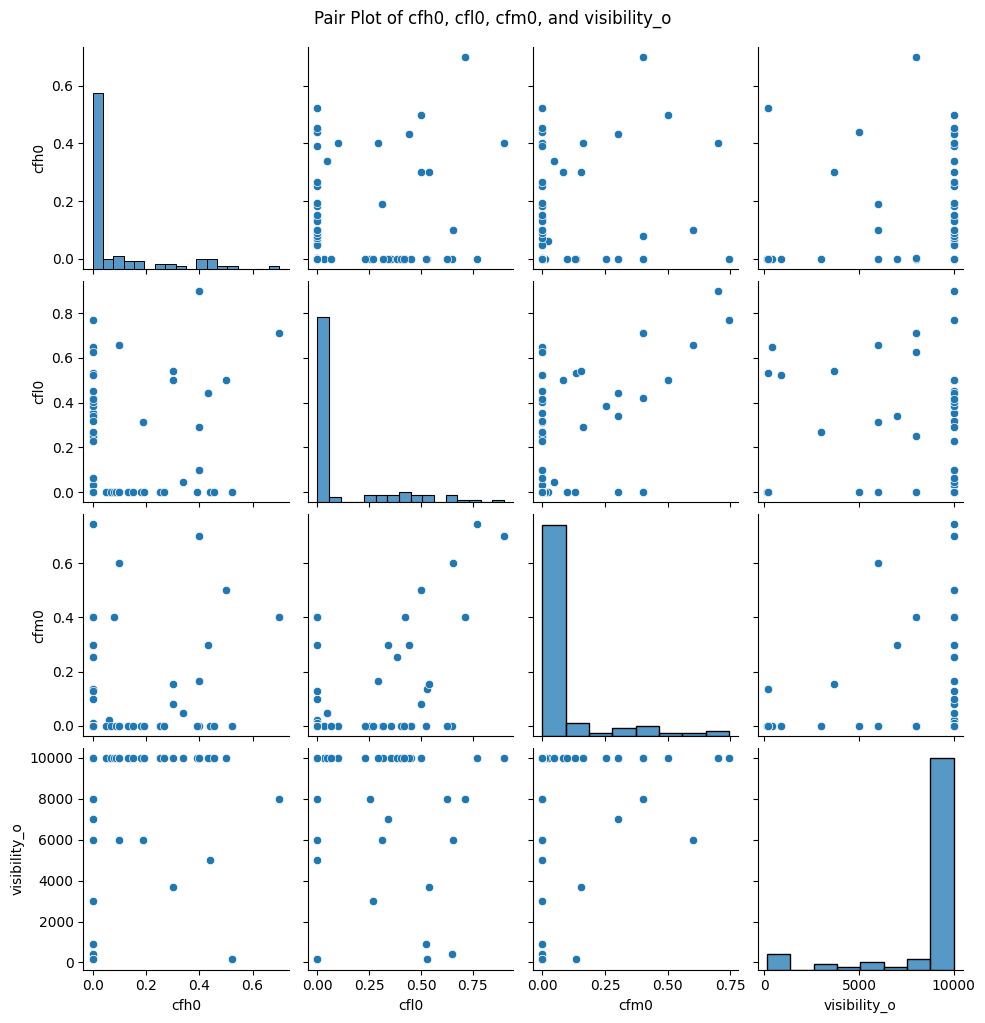

In [ ]:
#@title Clouds
df_clo = pd.concat([df_all[['cfh0', 'cfl0', 'cfm0']],station_raw['visibility_o']],axis=1).dropna().sample(100)
display(df_clo.corr())
sns.pairplot(df_clo)
plt.suptitle('Pair Plot of cfh0, cfl0, cfm0, and visibility_o', y=1.02)
plt.show()


In [ ]:
def transform_value(val):
    first_decimal = int(str(val)[2]) if len(str(val)) > 2 else 0
    return f'CL{first_decimal}'

df_all["cfl0"] = round(df_all["cfl0"],1)
df_all['cfl0_l'] = df_all['cfl0'].apply(transform_value)
df_all[["cfl0","cfl0_l"]]

,cfl0,cfl0_l
time,,
2018-01-01 01:00:00,0.0,CL0
2018-01-01 02:00:00,0.0,CL0
2018-01-01 03:00:00,0.2,CL2
2018-01-01 04:00:00,0.5,CL5
2018-01-01 05:00:00,0.4,CL4
...,...,...
2022-12-31 19:00:00,0.4,CL4
2022-12-31 20:00:00,0.3,CL3
2022-12-31 21:00:00,0.5,CL5


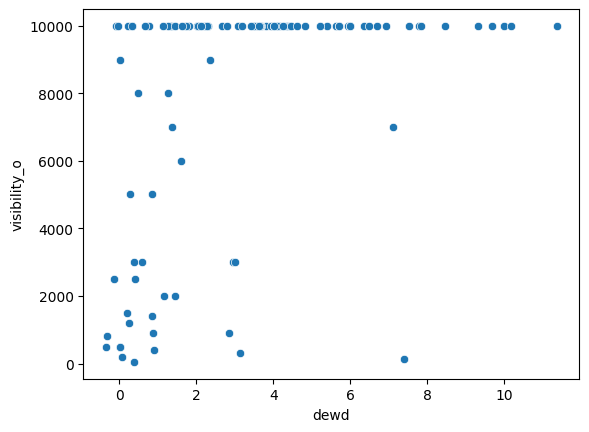

In [ ]:
#@title Temperature minus temperature dew point
#dew_temperature = dry_temperature - (100 - relative_humidity) / 5
df_all["dewd"] = df_all["temp0"]-round(df_all["temp0"]- (100 - df_all["rh0"]*100) / 5,0)
vis = pd.concat([df_all["dewd"],station_raw["visibility_o"]],axis=1).dropna()
vis.describe()
sns.scatterplot(vis.sample(100),x="dewd",y="visibility_o");

In [ ]:
vis.describe()

,dewd,visibility_o
count,41257.000000,41257.000000
mean,3.658260,8476.335967
std,3.086027,3078.104903
min,-0.499908,48.000000
25%,1.136047,8996.000000
50%,2.936127,9994.000000
75%,5.541687,9994.000000
max,14.287872,9994.000000
